In [53]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Viewing the Dataframe

In [54]:
location = r"C:\Users\madhu\Machine Learning\IBM DS\Coursera_capstone-master\Coursera_capstone-master\data\complete_dataset.csv"
df = pd.read_csv(location)
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome
0,Central,Cantonment area,12.972442,77.580643,866377,Bangalore,18944.099792
1,Central,Domlur,12.960992,77.638726,743186,Bangalore,56837.022198
2,Central,Indiranagar,12.971891,77.641151,474289,Bangalore,41991.817435
3,Central,Jeevanbheemanagar,12.962900,77.659500,527874,Bangalore,6667.447632
4,Central,Malleswaram,13.003100,77.564300,893629,Bangalore,53270.063892


### Analyzing Borough's and its population

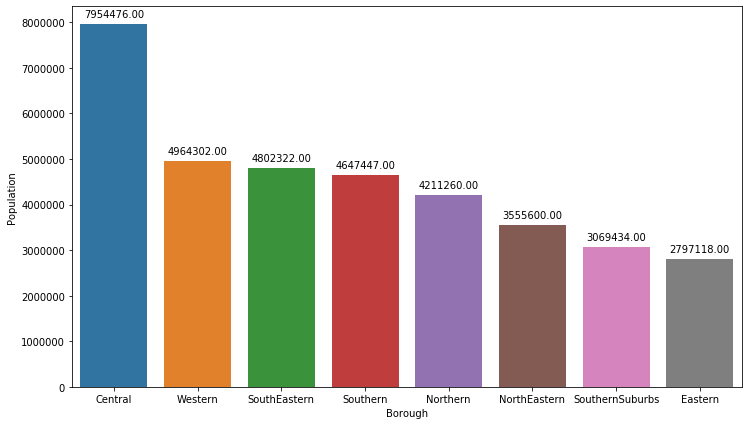

In [55]:
df_borough_population = df.groupby(['Borough'])['Population'].sum()
df_borough_population = df_borough_population.rename_axis('Borough').reset_index(name='Population').\
                        sort_values('Population', ascending=False)
plt.figure(figsize=(12,7))
g = sns.barplot(x='Borough', y='Population', data=df_borough_population)

for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center',\
               xytext = (0, 10), textcoords = 'offset points')
plt.show()


### Unique values of Neighborhoods's

In [56]:
print(df.Neighborhoods.unique())

['Cantonment area' 'Domlur' 'Indiranagar' 'Jeevanbheemanagar'
 'Malleswaram' 'Pete area' 'Rajajinagar' 'Sadashivanagar' 'Seshadripuram'
 'Shivajinagar' 'Ulsoor' 'Vasanth Nagar' 'Bellandur' 'CV Raman Nagar'
 'Hoodi' 'Krishnarajapuram' 'Mahadevapura' 'Marathahalli' 'Varthur'
 'Whitefield' 'Banaswadi' 'HBR Layout' 'Horamavu' 'Kammanahalli'
 'Lingarajapuram' 'Ramamurthy Nagar' 'Hebbal' 'Jalahalli' 'Mathikere'
 'Peenya' 'R. T. Nagar' 'Vidyaranyapura' 'Yelahanka' 'Yeshwanthpur'
 'Bommanahalli' 'Bommasandra' 'BTM Layout' 'Electronic City' 'HSR Layout'
 'Koramangala' 'Madiwala' 'Banashankari' 'Basavanagudi' 'Girinagar'
 'J. P. Nagar' 'Jayanagar' 'Kumaraswamy Layout' 'Padmanabhanagar'
 'Uttarahalli' 'Anjanapura' 'Arekere' 'Begur' 'Gottigere' 'Hulimavu'
 'Kothnur' 'Basaveshwaranagar' 'Kamakshipalya' 'Kengeri'
 'Mahalakshmi Layout' 'Nagarbhavi' 'Nandini Layout' 'Nayandahalli'
 'Rajarajeshwari Nagar' 'Vijayanagar']


### Foursquare credentials

In [57]:
#### Foursquare credentials

CLIENT_ID = 'ZYNZOLKUVZPXE00XVKXTCU2YAMPJSZ5IL4BEAXMLHS2PAFCB' # your Foursquare ID
CLIENT_SECRET = '1PUR1453XNXSCKLUJM51VGZI4FTOE3ZEW55S5C1F3205PQDM' # your Foursquare Secret
VERSION = '23200522' # Foursquare API version
radius = 500
LIMIT = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZYNZOLKUVZPXE00XVKXTCU2YAMPJSZ5IL4BEAXMLHS2PAFCB
CLIENT_SECRET:1PUR1453XNXSCKLUJM51VGZI4FTOE3ZEW55S5C1F3205PQDM


### Exploring Bangalore Neighborhoods

In [58]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [59]:
bangalore_venues = getNearbyVenues(names=df['Neighborhoods'],
                                   boro = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Fetching venues for :  Cantonment area
Fetching venues for :  Domlur
Fetching venues for :  Indiranagar
Fetching venues for :  Jeevanbheemanagar
Fetching venues for :  Malleswaram
Fetching venues for :  Pete area
Fetching venues for :  Rajajinagar
Fetching venues for :  Sadashivanagar
Fetching venues for :  Seshadripuram
Fetching venues for :  Shivajinagar
Fetching venues for :  Ulsoor
Fetching venues for :  Vasanth Nagar
Fetching venues for :  Bellandur
Fetching venues for :  CV Raman Nagar
Fetching venues for :  Hoodi
Fetching venues for :  Krishnarajapuram
Fetching venues for :  Mahadevapura
Fetching venues for :  Marathahalli
Fetching venues for :  Varthur
Fetching venues for :  Whitefield
Fetching venues for :  Banaswadi
Fetching venues for :  HBR Layout
Fetching venues for :  Horamavu
Fetching venues for :  Kammanahalli
Fetching venues for :  Lingarajapuram
Fetching venues for :  Ramamurthy Nagar
Fetching venues for :  Hebbal
Fetching venues for :  Jalahalli
Fetching venues for :

In [60]:
bangalore_venues.head()

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,Central,12.972442,77.580643,Hotel Fishland,12.975569,77.578592,Seafood Restaurant
1,Cantonment area,Central,12.972442,77.580643,Adigas Hotel,12.973554,77.579161,Restaurant
2,Cantonment area,Central,12.972442,77.580643,Sapna Book House,12.976355,77.578461,Bookstore
3,Cantonment area,Central,12.972442,77.580643,Vasudev Adigas,12.973707,77.579257,Indian Restaurant
4,Cantonment area,Central,12.972442,77.580643,Kamat Yatrinivas,12.975985,77.578125,Indian Restaurant


In [9]:
print('There are a total of {} Venue Categories in Bangalore'.format(bangalore_venues['Venue Category'].value_counts().shape[0]))

There are a total of 134 Venue Categories in Bangalore


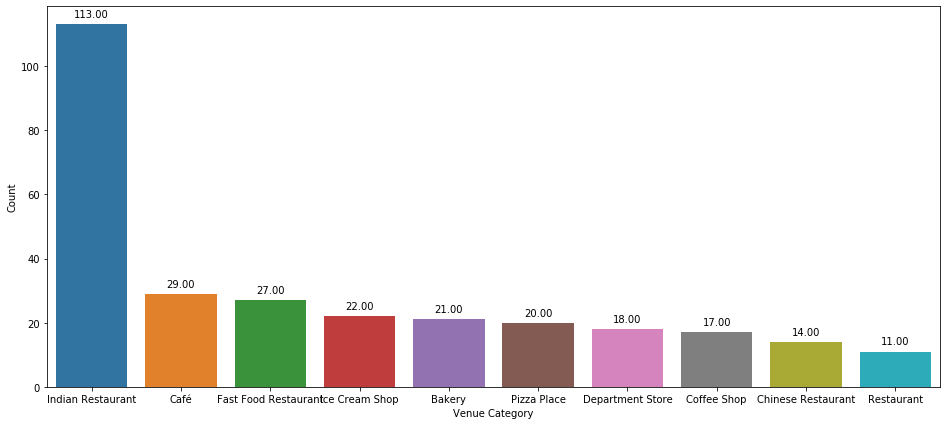

In [10]:
venues = bangalore_venues.groupby('Venue Category')['Neighborhood'].count().sort_values(ascending=False).head(10)
venues = venues.rename_axis().reset_index(name='Count')

plt.figure(figsize=(16,7))
g = sns.barplot(x = 'Venue Category', y='Count', data=venues)
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center',\
               xytext = (0, 10), textcoords = 'offset points')
plt.show()

#### How the number of Venues in each Borough is in consense with the income accumulated in the borough

In [67]:
df_venuecount = bangalore_venues.groupby(['Borough'])['Venue Category'].count().rename_axis().\
                reset_index(name='Venue Category Count')
df_incomeaccu = df.groupby(['Borough'])['AverageIncome'].sum().rename_axis().reset_index(name='Accumulated Income')

In [68]:
df_merged = pd.merge(df_venuecount, df_incomeaccu, on='Borough', how='inner')
df_merged

,Borough,Venue Category Count,Accumulated Income
0,Central,173,530767.678669
1,Eastern,56,296524.785615
2,NorthEastern,31,245884.497290
3,Northern,46,264219.534806
4,SouthEastern,88,194695.402586
5,Southern,89,353238.875859
6,SouthernSuburbs,46,250036.896531
7,Western,59,290339.761023


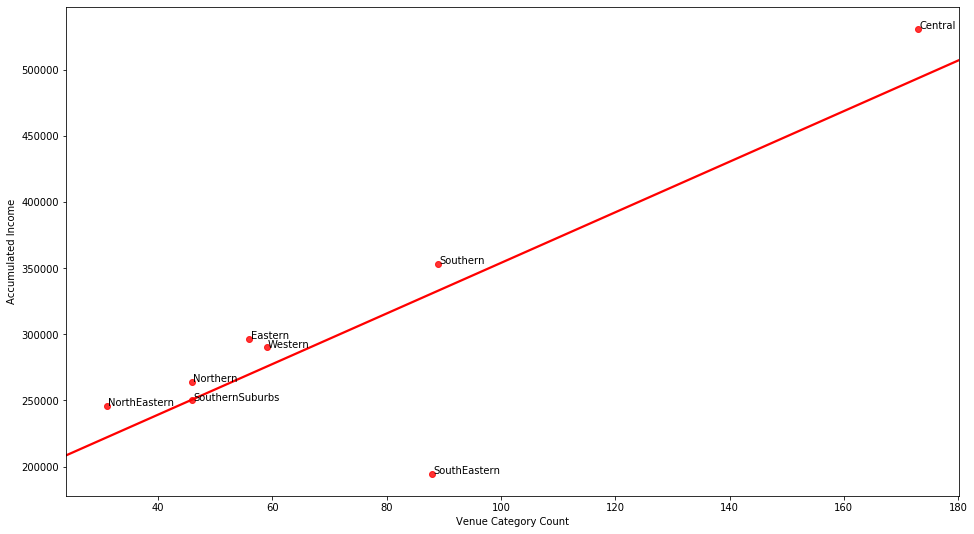

In [69]:
plt.figure(figsize=(16,9))
g = sns.regplot(x='Venue Category Count', y='Accumulated Income', data=df_merged, color='red', ci=None)
for line in range(0,df_merged.shape[0]):
     g.text(df_merged['Venue Category Count'][line]+0.2, df_merged['Accumulated Income'][line], df_merged.Borough[line], \
            horizontalalignment='left', size='medium', color='black')
plt.show()

**Interesting Outlier** : Despite the low accumulated income The SouthEastern borough has high number of venues

### Exploring Venues by Neighborhood

In [70]:
bangalore_venues.groupby(['Neighborhood'])['Venue'].count().sort_values(ascending=False).head()

Neighborhood
Indiranagar      65
BTM Layout       35
Arekere          27
Vasanth Nagar    26
J. P. Nagar      25
Name: Venue, dtype: int64

**Finding :** IndiraNagar has the highest number of venues

#### Exploring IndiraNagar

In [71]:
bangalore_venues[bangalore_venues.Neighborhood=='Indiranagar'].head()

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
16,Indiranagar,Central,12.971891,77.641151,Vero Moda,12.972808,77.641225,Boutique
17,Indiranagar,Central,12.971891,77.641151,Smoor Chocolates by Bliss,12.969913,77.641283,Chocolate Shop
18,Indiranagar,Central,12.971891,77.641151,Krispy Kreme Doughnuts,12.970094,77.640671,Bakery
19,Indiranagar,Central,12.971891,77.641151,The Black Rabbit,12.969891,77.641251,Pub
20,Indiranagar,Central,12.971891,77.641151,Mother Cluckers,12.970176,77.640243,Restaurant


In [72]:
bangalore_venues_onehot = pd.get_dummies(bangalore_venues[['Venue Category']])
bangalore_venues_onehot.head()

,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,Venue Category_Bar,Venue Category_Bengali Restaurant,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Café,Venue Category_Chaat Place,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Flea Market,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_French Restaurant,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gourmet Shop,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Halal Restaurant,Venue Category_Historic Site,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Hyderabadi Restaurant,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Chinese Restaurant,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Karnataka Restaurant,Venue Category_Kerala Restaurant,Venue Category_Kids Store,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Motorcycle Shop,Venue Category_Movie Theater,Venue Category_Mughlai Restaurant,Venue Category_Multiplex,Venue Category_Music Venue,Venue Category_Neighborhood,Venue Category_Nightclub,Venue Category_North Indian Restaurant,Venue Category_Optical Shop,Venue Category_Outlet Store,Venue Category_Paintball Field,Venue Category_Park,Venue Category_Performing Arts Venue,Venue Category_Pharmacy,Venue Category_Pizza Place,Venue Category_Playground,Venue Category_Plaza,Venue Category_Pool,Venue Category_Pub,Venue Category_Punjabi Restaurant,Venue Category_Rajasthani Restaurant,Venue Category_Rental Car Location,Venue Category_Resort,Venue Category_Restaurant,Venue Category_Road,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Shoe Store,Venue Category_Shop & Service,Venue Category_Shopping Mall,Venue Category_Smoke Shop,Venue Category_Snack Place,Venue Category_South Indian Restaurant,Venue Category_Spa,Venue Category_Sporting Goods Shop,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Supermarket,Venue Category_Sushi Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Wine Bar,Venue Category_Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [73]:
bangalore_venues_onehot['Neighborhood'] = bangalore_venues['Neighborhood']
columns = [bangalore_venues_onehot.columns[-1]] + list(bangalore_venues_onehot.columns[:-1])
bangalore_venues_onehot = bangalore_venues_onehot[columns]

In [74]:
bangalore_venues_grouped = bangalore_venues_onehot.groupby(['Neighborhood']).mean().reset_index()
bangalore_venues_grouped.head()

,Neighborhood,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,Venue Category_Bar,Venue Category_Bengali Restaurant,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Café,Venue Category_Chaat Place,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Flea Market,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_French Restaurant,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gourmet Shop,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Halal Restaurant,Venue Category_Historic Site,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Hyderabadi Restaurant,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Chinese Restaurant,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Karnataka Restaurant,Venue Category_Kerala Restaurant,Venue Category_Kids Store,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Motorcycle Shop,Venue Category_Movie Theater,Venue Category_Mughlai Restaurant,Venue Category_Multiplex,Venue Category_Music Venue,Venue Category_Neighborhood,Venue Category_Nightclub,Venue Category_North Indian Restaurant,Venue Category_Optical Shop,Venue Category_Outlet Store,Venue Category_Paintball Field,Venue Category_Park,Venue Category_Performing Arts Venue,Venue Category_Pharmacy,Venue Category_Pizza Place,Venue Category_Playground,Venue Category_Plaza,Venue Category_Pool,Venue Category_Pub,Venue Category_Punjabi Restaurant,Venue Category_Rajasthani Restaurant,Venue Category_Rental Car Location,Venue Category_Resort,Venue Category_Restaurant,Venue Category_Road,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Shoe Store,Venue Category_Shop & Service,Venue Category_Shopping Mall,Venue Category_Smoke Shop,Venue Category_Snack Place,Venue Category_South Indian Restaurant,Venue Category_Spa,Venue Category_Sporting Goods Shop,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Supermarket,Venue Category_Sushi Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Wine Bar,Venue Category_Women's Store
0,Anjanapura,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0

In [75]:
number_of_top_venues = 5
for hood in bangalore_venues_grouped['Neighborhood']:
    print('---------',hood,'---------')
    temp = bangalore_venues_grouped[bangalore_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(number_of_top_venues))
    print('\n')

--------- Anjanapura ---------
                                  Venue  Frequency
0                    Venue Category_ATM        1.0
1      Venue Category_Mobile Phone Shop        0.0
2               Venue Category_Pharmacy        0.0
3  Venue Category_Performing Arts Venue        0.0
4                   Venue Category_Park        0.0


--------- Arekere ---------
                                Venue  Frequency
0    Venue Category_Indian Restaurant       0.19
1  Venue Category_Sporting Goods Shop       0.15
2          Venue Category_Pizza Place       0.07
3     Venue Category_Department Store       0.07
4         Venue Category_Liquor Store       0.04


--------- BTM Layout ---------
                                 Venue  Frequency
0     Venue Category_Indian Restaurant       0.20
1           Venue Category_Snack Place       0.09
2        Venue Category_Ice Cream Shop       0.09
3  Venue Category_Fast Food Restaurant       0.06
4                Venue Category_Bakery       0.06


----

                                 Venue  Frequency
0        Venue Category_Sandwich Place        0.2
1                  Venue Category_Café        0.1
2    Venue Category_Chinese Restaurant        0.1
3  Venue Category_Fast Food Restaurant        0.1
4          Venue Category_Burger Joint        0.1


--------- Lingarajapuram ---------
                                    Venue  Frequency
0                      Venue Category_ATM        0.5
1            Venue Category_Train Station        0.5
2  Venue Category_North Indian Restaurant        0.0
3            Venue Category_Movie Theater        0.0
4       Venue Category_Mughlai Restaurant        0.0


--------- Madiwala ---------
                                 Venue  Frequency
0     Venue Category_Indian Restaurant       0.33
1  Venue Category_Fast Food Restaurant       0.08
2   Venue Category_Indie Movie Theater       0.04
3           Venue Category_Snack Place       0.04
4     Venue Category_Kerala Restaurant       0.04


--------- Ma

In [76]:
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

In [77]:
number_of_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_venues_grouped['Neighborhood']

for ind in np.arange(bangalore_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_venues_grouped.iloc[ind, :], number_of_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,Venue Category_ATM,Venue Category_Furniture / Home Store,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant
1,Arekere,Venue Category_Indian Restaurant,Venue Category_Sporting Goods Shop,Venue Category_Department Store,Venue Category_Pizza Place,Venue Category_Gym / Fitness Center,Venue Category_Liquor Store,Venue Category_Fast Food Restaurant,Venue Category_Mughlai Restaurant,Venue Category_Neighborhood,Venue Category_Chinese Restaurant
2,BTM Layout,Venue Category_Indian Restaurant,Venue Category_Snack Place,Venue Category_Ice Cream Shop,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Pizza Place,Venue Category_Coffee Shop,Venue Category_Chinese Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Bakery,Venue Category_Sandwich Place
3,Banashankari,Venue Category_Café,Venue Category_Indian Restaurant,Venue Category_Shoe Store,Venue Category_Miscellaneous Shop,Venue Category_North Indian Restaurant,Venue Category_Park,Venue Category_Clothing Store,Venue Category_Pizza Place,Venue Category_Accessories Store,Venue Category_BBQ Joint
4,Banaswadi,Venue Category_Indian Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Convenience Store,Venue Category_Café,Venue Category_Bakery,Venue Category_Fast Food Restaurant,Venue Category_Food Court,Venue Category_Food & Drink Shop,Venue Category_Flea Market,Venue Category_Fish & Chips Shop


In [78]:
neighborhoods_venues_sorted.shape

(64, 11)

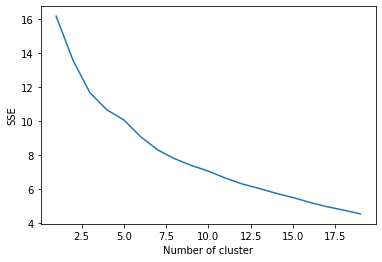

In [79]:
sse = {}

for k in range(1,20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(bangalore_venues_grouped.drop(['Neighborhood'], axis=1))
    bangalore_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

**Elbow curve shows that optimum number of clusters are two**

In [80]:
kmeans = KMeans(n_clusters=10,random_state=0)
kmeans.fit(bangalore_venues_grouped.drop('Neighborhood',axis=1))
bangalore_venues_grouped['Cluster'] = kmeans.labels_

In [81]:
bangalore_venues_grouped.groupby('Cluster')['Neighborhood'].count()

Cluster
0     8
1     8
2    16
3     3
4     3
5     3
6    17
7     2
8     3
9     1
Name: Neighborhood, dtype: int64

In [82]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues_grouped,on='Neighborhood')

In [83]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(bangalore_venues,on='Neighborhood')

In [84]:
latitude_bangalore = df['Latitude'].mean()
longitude_bangalore = df['Longitude'].mean()

In [85]:
unique_boroughs_of_bangalore = df['Borough'].unique().tolist()
borough_colors ={}
for i in unique_boroughs_of_bangalore:
    borough_colors[i] = '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3))

In [86]:
borough_colors

{'Central': '#EBB72F',
 'Eastern': '#8C9A50',
 'NorthEastern': '#90C92D',
 'Northern': '#D3FBD5',
 'SouthEastern': '#ABCF95',
 'Southern': '#FF7DB6',
 'SouthernSuburbs': '#9A9087',
 'Western': '#A548A8'}

In [90]:
map_clusters = folium.Map(location=[latitude_bangalore, longitude_bangalore], zoom_start=11)

# set color scheme for the clusters
x = np.arange(10)
ys = [i + x + (i*x)**2 for i in range(10)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Neighborhood Latitude'], neighborhoods_venues_sorted['Neighborhood Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

In [91]:
map_clusters

In [92]:
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
income_df = df[['Borough', 'Neighborhoods', 'AverageIncome']]
income_df['Normalized_income'] = income_df['AverageIncome']/income_df['AverageIncome'].max(axis=0)
income_df.head()

,Borough,Neighborhoods,AverageIncome,Normalized_income
0,Central,Cantonment area,18944.099792,0.293051
1,Central,Domlur,56837.022198,0.879225
2,Central,Indiranagar,41991.817435,0.649581
3,Central,Jeevanbheemanagar,6667.447632,0.103140
4,Central,Malleswaram,53270.063892,0.824047


In [93]:
population_df = df[['Borough', 'Neighborhoods', 'Population']]
population_df['Normalized_Population'] = population_df['Population']/population_df['Population'].max(axis=0)
population_df.head()

,Borough,Neighborhoods,Population,Normalized_Population
0,Central,Cantonment area,866377,0.880810
1,Central,Domlur,743186,0.755567
2,Central,Indiranagar,474289,0.482190
3,Central,Jeevanbheemanagar,527874,0.536668
4,Central,Malleswaram,893629,0.908516


In [94]:
bangalore_veg_rest = bangalore_venues_onehot.groupby(['Neighborhood']).sum().reset_index()
bangalore_veg_rest = bangalore_veg_rest[['Neighborhood','Venue Category_Vegetarian / Vegan Restaurant']]
bangalore_veg_rest.head()

,Neighborhood,Venue Category_Vegetarian / Vegan Restaurant
0,Anjanapura,0
1,Arekere,0
2,BTM Layout,2
3,Banashankari,0
4,Banaswadi,1


In [95]:
bangalore_veg_rest.rename(columns={'Venue Category_Vegetarian / Vegan Restaurant':'NumberOfVegRestaurants'},inplace=True)
bangalore_veg_rest['NumberOfNonVeganrestaurants'] = 1-(bangalore_veg_rest['NumberOfVegRestaurants']/bangalore_veg_rest['NumberOfVegRestaurants'].max(axis=0))
bangalore_veg_rest.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)
bangalore_veg_rest.head()

,Neighborhoods,NumberOfVegRestaurants,NumberOfNonVeganrestaurants
0,Anjanapura,0,1.0
1,Arekere,0,1.0
2,BTM Layout,2,0.0
3,Banashankari,0,1.0
4,Banaswadi,1,0.5


### Building a target neighborhood by providing a sample restaurant : say ' Indiranagar '

In [96]:
target_cluster_dataframe = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Indiranagar']
target_cluster_dataframe.reset_index().head()

,index,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,Venue Category_Bar,Venue Category_Bengali Restaurant,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Café,Venue Category_Chaat Place,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Flea Market,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_French Restaurant,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gourmet Shop,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Halal Restaurant,Venue Category_Historic Site,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Hyderabadi Restaurant,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Chinese Restaurant,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Karnataka Restaurant,Venue Category_Kerala Restaurant,Venue Category_Kids Store,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Motorcycle Shop,Venue Category_Movie Theater,Venue Category_Mughlai Restaurant,Venue Category_Multiplex,Venue Category_Music Venue,Venue Category_Neighborhood,Venue Category_Nightclub,Venue Category_North Indian Restaurant,Venue Category_Optical Shop,Venue Category_Outlet Store,Venue Category_Paintball Field,Venue Category_Park,Venue Category_Performing Arts Venue,Venue Category_Pharmacy,Venue Category_Pizza Place,Venue Category_Playground,Venue Category_Plaza,Venue Category_Pool,Venue Category_Pub,Venue Category_Punjabi Restaurant,Venue Category_Rajasthani Restaurant,Venue Category_Rental Car Location,Venue Category_Resort,Venue Category_Restaurant,Venue Category_Road,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Shoe Store,Venue Category_Shop & Service,Venue Category_Shopping Mall,Venue Category_Smoke Shop,Venue Category_Snack Place,Venue Category_South Indian Restaurant,Venue Category_Spa,Venue Category_Sporting Goods Shop,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Supermarket,Venue Category_Sushi Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restauran

In [97]:
target_cluster = target_cluster_dataframe.iloc[0].at['Cluster']
print('target cluster is :',target_cluster)

target cluster is : 2


In [98]:
possible_neighborhoods = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster']==target_cluster]
possible_neighborhoods.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,Venue Category_Bar,Venue Category_Bengali Restaurant,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Café,Venue Category_Chaat Place,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Flea Market,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_French Restaurant,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gourmet Shop,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Halal Restaurant,Venue Category_Historic Site,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Hyderabadi Restaurant,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Chinese Restaurant,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Karnataka Restaurant,Venue Category_Kerala Restaurant,Venue Category_Kids Store,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Motorcycle Shop,Venue Category_Movie Theater,Venue Category_Mughlai Restaurant,Venue Category_Multiplex,Venue Category_Music Venue,Venue Category_Neighborhood,Venue Category_Nightclub,Venue Category_North Indian Restaurant,Venue Category_Optical Shop,Venue Category_Outlet Store,Venue Category_Paintball Field,Venue Category_Park,Venue Category_Performing Arts Venue,Venue Category_Pharmacy,Venue Category_Pizza Place,Venue Category_Playground,Venue Category_Plaza,Venue Category_Pool,Venue Category_Pub,Venue Category_Punjabi Restaurant,Venue Category_Rajasthani Restaurant,Venue Category_Rental Car Location,Venue Category_Resort,Venue Category_Restaurant,Venue Category_Road,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Shoe Store,Venue Category_Shop & Service,Venue Category_Shopping Mall,Venue Category_Smoke Shop,Venue Category_Snack Place,Venue Category_South Indian Restaurant,Venue Category_Spa,Venue Category_Sporting Goods Shop,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Supermarket,Venue Category_Sushi Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Venu

In [99]:
print("There are {} neighborhoods which has similar characteristics to Indiranagar.".format(possible_neighborhoods.shape[0]))

There are 255 neighborhoods which has similar characteristics to Indiranagar.


In [100]:
possible_neighborhoods.reset_index().head()

,index,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,Venue Category_Bar,Venue Category_Bengali Restaurant,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Café,Venue Category_Chaat Place,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Flea Market,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_French Restaurant,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gourmet Shop,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Halal Restaurant,Venue Category_Historic Site,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Hyderabadi Restaurant,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Chinese Restaurant,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Karnataka Restaurant,Venue Category_Kerala Restaurant,Venue Category_Kids Store,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Motorcycle Shop,Venue Category_Movie Theater,Venue Category_Mughlai Restaurant,Venue Category_Multiplex,Venue Category_Music Venue,Venue Category_Neighborhood,Venue Category_Nightclub,Venue Category_North Indian Restaurant,Venue Category_Optical Shop,Venue Category_Outlet Store,Venue Category_Paintball Field,Venue Category_Park,Venue Category_Performing Arts Venue,Venue Category_Pharmacy,Venue Category_Pizza Place,Venue Category_Playground,Venue Category_Plaza,Venue Category_Pool,Venue Category_Pub,Venue Category_Punjabi Restaurant,Venue Category_Rajasthani Restaurant,Venue Category_Rental Car Location,Venue Category_Resort,Venue Category_Restaurant,Venue Category_Road,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Shoe Store,Venue Category_Shop & Service,Venue Category_Shopping Mall,Venue Category_Smoke Shop,Venue Category_Snack Place,Venue Category_South Indian Restaurant,Venue Category_Spa,Venue Category_Sporting Goods Shop,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Supermarket,Venue Category_Sushi Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restauran

In [101]:
possible_neighborhoods.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

### Now we need to create ranking by combining population and income factors as well?

In [102]:
possible_neighborhoods = possible_neighborhoods.merge(population_df[['Neighborhoods','Population','Normalized_Population']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(income_df[['Neighborhoods','AverageIncome','Normalized_income']],on='Neighborhoods')
possible_neighborhoods = possible_neighborhoods.merge(bangalore_veg_rest[['Neighborhoods','NumberOfVegRestaurants','NumberOfNonVeganrestaurants']],on='Neighborhoods')

In [103]:
possible_neighborhoods.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Andhra Restaurant,Venue Category_Art Museum,Venue Category_Asian Restaurant,Venue Category_Athletics & Sports,Venue Category_Auto Garage,Venue Category_BBQ Joint,Venue Category_Badminton Court,Venue Category_Bakery,Venue Category_Bar,Venue Category_Bengali Restaurant,Venue Category_Bistro,Venue Category_Bookstore,Venue Category_Boutique,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Bus Line,Venue Category_Bus Station,Venue Category_Bus Stop,Venue Category_Business Service,Venue Category_Café,Venue Category_Chaat Place,Venue Category_Chinese Restaurant,Venue Category_Chocolate Shop,Venue Category_Clothing Store,Venue Category_Cocktail Bar,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Cupcake Shop,Venue Category_Deli / Bodega,Venue Category_Department Store,Venue Category_Dessert Shop,Venue Category_Dim Sum Restaurant,Venue Category_Diner,Venue Category_Donut Shop,Venue Category_Drugstore,Venue Category_Eastern European Restaurant,Venue Category_Electronics Store,Venue Category_Falafel Restaurant,Venue Category_Fast Food Restaurant,Venue Category_Fish & Chips Shop,Venue Category_Flea Market,Venue Category_Food & Drink Shop,Venue Category_Food Court,Venue Category_Food Truck,Venue Category_French Restaurant,Venue Category_Furniture / Home Store,Venue Category_Gas Station,Venue Category_Gastropub,Venue Category_Gourmet Shop,Venue Category_Grocery Store,Venue Category_Gym,Venue Category_Gym / Fitness Center,Venue Category_Halal Restaurant,Venue Category_Historic Site,Venue Category_Home Service,Venue Category_Hookah Bar,Venue Category_Hotel,Venue Category_Hotel Bar,Venue Category_Hyderabadi Restaurant,Venue Category_IT Services,Venue Category_Ice Cream Shop,Venue Category_Indian Chinese Restaurant,Venue Category_Indian Restaurant,Venue Category_Indie Movie Theater,Venue Category_Italian Restaurant,Venue Category_Juice Bar,Venue Category_Karnataka Restaurant,Venue Category_Kerala Restaurant,Venue Category_Kids Store,Venue Category_Korean Restaurant,Venue Category_Lake,Venue Category_Liquor Store,Venue Category_Lounge,Venue Category_Market,Venue Category_Mediterranean Restaurant,Venue Category_Men's Store,Venue Category_Metro Station,Venue Category_Mexican Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Miscellaneous Shop,Venue Category_Mobile Phone Shop,Venue Category_Motorcycle Shop,Venue Category_Movie Theater,Venue Category_Mughlai Restaurant,Venue Category_Multiplex,Venue Category_Music Venue,Venue Category_Neighborhood,Venue Category_Nightclub,Venue Category_North Indian Restaurant,Venue Category_Optical Shop,Venue Category_Outlet Store,Venue Category_Paintball Field,Venue Category_Park,Venue Category_Performing Arts Venue,Venue Category_Pharmacy,Venue Category_Pizza Place,Venue Category_Playground,Venue Category_Plaza,Venue Category_Pool,Venue Category_Pub,Venue Category_Punjabi Restaurant,Venue Category_Rajasthani Restaurant,Venue Category_Rental Car Location,Venue Category_Resort,Venue Category_Restaurant,Venue Category_Road,Venue Category_Sandwich Place,Venue Category_Seafood Restaurant,Venue Category_Shoe Store,Venue Category_Shop & Service,Venue Category_Shopping Mall,Venue Category_Smoke Shop,Venue Category_Snack Place,Venue Category_South Indian Restaurant,Venue Category_Spa,Venue Category_Sporting Goods Shop,Venue Category_Sports Bar,Venue Category_Steakhouse,Venue Category_Supermarket,Venue Category_Sushi Restaurant,Venue Category_Tea Room,Venue Category_Tex-Mex Restaurant,Venue Category_Toll Plaza,Venue Category_Train Station,Venue Category_Travel & Transport,Venue Category_Udupi Restaurant,Ven

In [104]:
possible_neighborhoods['Ranking'] = possible_neighborhoods['Normalized_Population'] * 0.5 + possible_neighborhoods['Normalized_income'] * 0.35 + possible_neighborhoods['NumberOfNonVeganrestaurants'] * 0.1
recommended_neighborhoods = possible_neighborhoods.sort_values(by='Ranking',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [105]:
top3 = recommended_neighborhoods.groupby(['Neighborhoods','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])['Ranking'].unique()
top3_df = pd.DataFrame(top3).reset_index()
top3_df.sort_values('Ranking', ascending=False).head(3)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Ranking
11,Rajajinagar,Venue Category_Bakery,Venue Category_Indian Restaurant,Venue Category_Café,[0.8789474204848435]
2,Domlur,Venue Category_Indian Restaurant,Venue Category_Café,Venue Category_BBQ Joint,[0.7855119911765059]
4,Hulimavu,Venue Category_Indian Restaurant,Venue Category_Bakery,Venue Category_South Indian Restaurant,[0.7638135476902764]


**Rajajinagar, Domlur, Hulimavu are the top neighborhoods to find simillar food as Indiranagar**

**Thank you!!**